##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification

このチュートリアルでは、花の画像を分類する方法を示します。`tf.keras.Sequential`モデルを使用して画像分類器を構築し、`tf.keras.utils.image_dataset_from_directory` を使用してデータを読み込みます。このチュートリアルでは、次の概念を実際に見ていきます。

- ディスク上のデータセットを効率的に読み込みます。
- 過学習を識別し、データ拡張やドロップアウトなどテクニックを使用して過学習を防ぎます。

このチュートリアルは、基本的な機械学習のワークフローに従います。

1. データの調査及び理解
2. 入力パイプラインの構築
3. モデルの構築
4. モデルの学習
5. モデルのテスト
6. モデルの改善とプロセスの繰り返し

## パッケージのインポート

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## データの読み込み

このチュートリアルでは、約3,700枚の花の写真のデータセットを使用します。データセットには、クラスごとに1つずつ、5 つのサブディレクトリが含まれています。

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [3]:
import pathlib
BASE_DIR =  os.getcwd()
data_dir = f"{BASE_DIR}/resources/"
data_dir = pathlib.Path(data_dir)

/Users/toshikatsu/develop/gitlab/image_classification/flower_photos


ダウンロード後、データセットのコピーが利用できるようになります。合計3,670枚の画像があります。

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


バラの画像です。

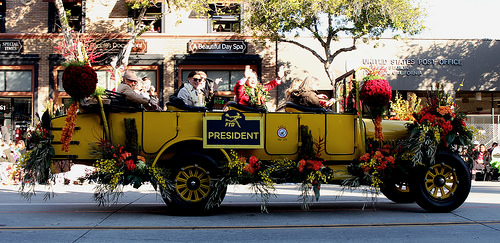

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

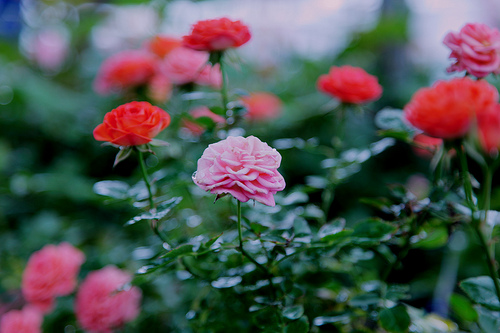

In [6]:
PIL.Image.open(str(roses[1]))

チューリップの画像です。

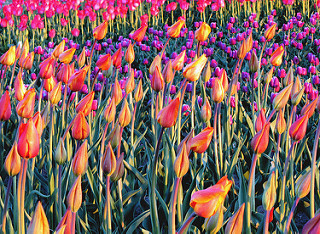

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

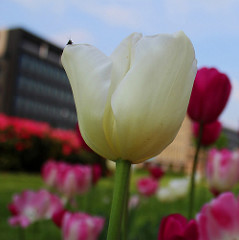

In [8]:
PIL.Image.open(str(tulips[1]))

# Keras ユーティリティを使用してデータを読み込む

便利な <a>image_dataset_from_directory</a> ユーティリティを使用して、これらの画像をディスクから読み込みます。これにより、数行のコードでディスク上の画像のディレクトリから`tf.data.Dataset`に移動します。また、[画像を読み込んで前処理する](../load_data/images.ipynb)チュートリアルにアクセスして、独自のデータ読み込みコードを最初から作成することもできます。

## データセットを作成する

ローダーのいくつかのパラメーターを定義します。

In [9]:
batch_size = 32
img_height = 180
img_width = 180

モデルを開発するときは、検証分割を使用することをお勧めします。ここでは、画像の80％をトレーニングに使用し、20％を検証に使用します。

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


クラス名は、これらのデータセットの`class_names`属性にあります。 これらはアルファベット順にディレクトリ名に対応します。

In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## データを視覚化する

以下はトレーニングデータセットの最初の 9 枚の画像です。

2023-10-21 14:18:22.928832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-10-21 14:18:22.929138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]
2023-10-21 14:18:22.960038: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


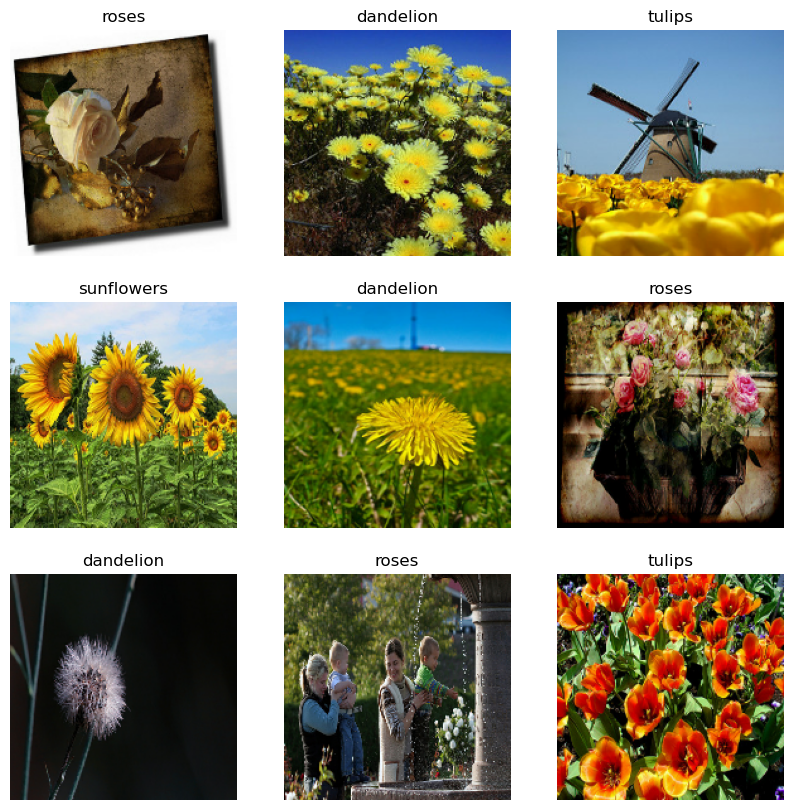

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

これらのデータセットを`model.fit`に渡すことで、これらのデータセットを使用してモデルをトレーニングします。 必要に応じて、データセットを手動で繰り返し、画像のバッチを取得することもできます。

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


2023-10-21 14:18:23.770222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-10-21 14:18:23.770520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


`image_batch`は、形状`(32, 180, 180, 3)`のテンソルです。これは、形状`180x180x3`の 32 枚の画像のバッチです（最後の次元はカラーチャンネル RGB を参照します）。`label_batch`は、形状`(32,)`のテンソルであり、これらは 32 枚の画像に対応するラベルです。

`image_batch`および`labels_batch`テンソルで`.numpy()`を呼び出して、それらを`numpy.ndarray`に変換できます。


## パフォーマンスのためにデータセットを構成する

I/O がブロックされることなくディスクからデータを取得できるように、必ずバッファ付きプリフェッチを使用します。これらは、データを読み込むときに使用する必要がある 2 つの重要な方法です。

- `Dataset.cache()`は、最初のエポック中に画像をディスクから読み込んだ後、メモリに保持します。これにより、モデルのトレーニング中にデータセットがボトルネックになることを回避できます。データセットが大きすぎてメモリに収まらない場合は、この方法を使用して、パフォーマンスの高いオンディスクキャッシュを作成することもできます。
- `Dataset.prefetch` はトレーニング中にデータの前処理とモデルの実行をオーバーラップさせます。

以上の 2 つの方法とデータをディスクにキャッシュする方法についての詳細は、<a>データパフォーマンスガイド</a>の <em>プリフェッチ</em>を参照してください。

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## データを標準化する

RGB チャネル値は `[0, 255]` の範囲にあり、ニューラルネットワークには理想的ではありません。一般に、入力値は小さくする必要があります。

ここでは、`tf.keras.layers.Rescaling` を使用して、値を `[0, 1]` の範囲に標準化します。

In [16]:
normalization_layer = layers.Rescaling(1./255)

このレイヤーを使用するには 2 つの方法があります。`Dataset.map` を呼び出すことにより、データセットに適用できます。

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

2023-10-21 14:18:23.984042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]
2023-10-21 14:18:23.984417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2936]
	 [[{{node Placeholder/_4}}]]


0.0 1.0


または、モデル定義内にレイヤーを含めることができます。これにより、デプロイメントを簡素化できます。 ここでは 2 番目のアプローチを使用します。

注意：以前は、`tf.keras.utils.image_dataset_from_directory` の `image_size` 引数を使用して画像のサイズを変更しました。モデルにサイズ変更ロジックも含める場合は、`tf.keras.layers.Resizing` レイヤーを使用できます。

# モデルを作成する

[Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルは、それぞれに最大プールレイヤー（`tf.keras.layers.MaxPooling2D`）を持つ3つの畳み込みブロック（`tf.keras.layers.Conv2D`）で構成されます。ReLU 活性化関数（`'relu'`）により活性化されたユニットが 128 個ある完全に接続されたレイヤー（`tf.keras.layers.Dense`）があります。このチュートリアルの目的は、標準的なアプローチを示すことなので、このモデルは高精度に調整されていません。

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## モデルをコンパイルする

このチュートリアルでは、`tf.keras.optimizers.Adam` オプティマイザと`tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を選択します。各トレーニングエポックのトレーニングと検証の精度を表示するには、`Model.compile` に `metrics` 引数を渡します。

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## モデルの概要

モデルの `Model.summary` メソッドを使用して、ネットワークのすべてのレイヤーを表示します。

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## モデルをトレーニングする

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2023-10-21 14:18:26.058585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]
2023-10-21 14:18:26.059022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2936]
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.4653

2023-10-21 14:18:56.506802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [734]
	 [[{{node Placeholder/_4}}]]
2023-10-21 14:18:56.507309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [734]
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 34s 364ms/step - loss: 1.2762 - accuracy: 0.4653 - val_loss: 1.1175 - val_accuracy: 0.5531
Epoch 2/10
92/92 [==============================] - 32s 349ms/step - loss: 0.9749 - accuracy: 0.6202 - val_loss: 1.0561 - val_accuracy: 0.6226
Epoch 3/10
92/92 [==============================] - 33s 356ms/step - loss: 0.7902 - accuracy: 0.6965 - val_loss: 0.8971 - val_accuracy: 0.6471
Epoch 4/10
92/92 [==============================] - 32s 351ms/step - loss: 0.5743 - accuracy: 0.7779 - val_loss: 1.0083 - val_accuracy: 0.6144
Epoch 5/10
92/92 [==============================] - 33s 355ms/step - loss: 0.3680 - accuracy: 0.8719 - val_loss: 1.0685 - val_accuracy: 0.6662
Epoch 6/10
92/92 [==============================] - 32s 351ms/step - loss: 0.2165 - accuracy: 0.9298 - val_loss: 1.2237 - val_accuracy: 0.6526
Epoch 7/10
92/92 [==============================] - 33s 358ms/step - loss: 0.1297 - accuracy: 0.9619 - val_loss: 1.3996 - val_accuracy: 0.6253
Epoch 8/10

## モデルを保存する

In [22]:
model.save("ramen_model")

INFO:tensorflow:Assets written to: ramen_model/assets


INFO:tensorflow:Assets written to: ramen_model/assets


## トレーニングの結果を視覚化する

トレーニングセットと検証セットで損失と精度のプロットを作成します。

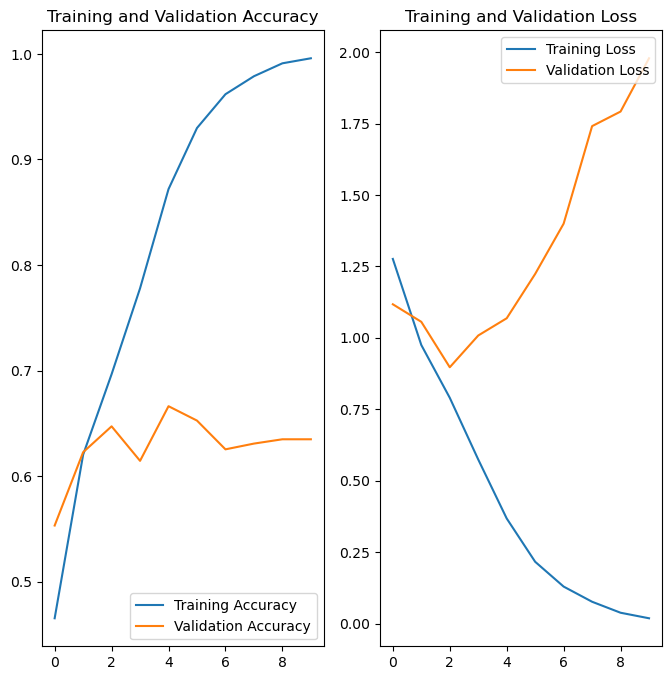

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

プロットには、トレーニングの精度と検証の精度は大幅にずれており、モデルは検証セットで約 60％ の精度しか達成していないことが示されています。

原因を調べ、モデルの全体的なパフォーマンスを向上させます。

## 過剰適合

上記のプロットでは、トレーニングの精度は時間の経過とともに直線的に増加していますが、検証の精度はトレーニングプロセスで約60％のままです。また、トレーニングと検証の精度に大きな違いがあり、これは[過剰適合](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)の兆候を示しています。

トレーニングサンプルの数が少ない場合、モデルは、トレーニングサンプルのノイズや不要な詳細から学習し、新しいサンプルでのモデルのパフォーマンスに悪影響を及ぼすことがあります。 この現象は過剰適合として知られています。 これは、モデルが新しいデータセットで一般化する上で問題があることを意味します。

トレーニングプロセスで過剰適合を回避する方法は複数あります。このチュートリアルでは、*データ拡張*を使用して、モデルに*ドロップアウト*を追加します。

## データ拡張

過剰適合は、一般に、トレーニングサンプルの数が少ない場合に発生します。[データ拡張](./data_augmentation.ipynb)は、既存のサンプルに対してランダムな変換を使用してサンプルを拡張することにより、追加のトレーニングデータを生成します。これにより、モデルをデータのより多くの側面でトレーニングし、より一般化することができます。

`tf.keras.layers.RandomFlip`、`tf.keras.layers.RandomRotation`、および `tf.keras.layers.RandomZoom` の前処理レイヤーを使用して、データ拡張を実装します。これらは、他のレイヤーと同様にモデル内に含めて、GPU で実行できます。

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

同じ画像にデータ拡張を数回適用して、いくつかの拡張されたデータがどのようになるかを視覚化してみましょう。

In [25]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

データ拡張を使用して、モデルをトレーニングします。

## ドロップアウト

過剰適合を回避するもう 1 つの方法は、[ドロップアウト](https://developers.google.com/machine-learning/glossary#dropout_regularization)正則化をネットワークに導入することです。

ドロップアウトをレイヤーに適用すると、トレーニングプロセス中にレイヤーからいくつかの出力ユニットがランダムにドロップアウトされます（アクティベーションをゼロに設定することにより）。ドロップアウトは、0.1、0.2、0.4 などの形式で、入力値として小数を取ります。これは、適用されたレイヤーから出力ユニットの 10％、20％、または 40％ をランダムにドロップアウトすることを意味します。

拡張された画像を使用してトレーニングする前に、`tf.keras.layers.Dropout` を使用して新しいニューラルネットワークを作成しましょう。

In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## モデルをコンパイルしてトレーニングする

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [ ]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


## トレーニングの結果を視覚化する

データ拡張と `tf.keras.layers.Dropout` を適用した後は、以前よりも過剰適合が少なくなり、トレーニングと検証がより高精度に調整されます。

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 新しいデータを予測する

最後に、モデルを使用して、トレーニングセットまたは検証セットに含まれていなかった画像を分類します。

注意：データ拡張レイヤーとドロップアウトレイヤーは、推論時に非アクティブになります。

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)